## 实例3:将图片制作成内存对象数据集

将图片样本数据来制作成数据集。使用TensorFlow的队列方式，充分使用CPU的多线程资源，让训练模型与数据读取以并行的方式同时运行，从而大大提升效率。

In [4]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [5]:
def load_sample(sample_dir):
    '''递归读取文件。只支持一级。返回文件名、数值标签、数值对应的标签名'''
    print ('loading sample  dataset..')
    lfilenames = []
    labelsnames = []
    for (dirpath, dirnames, filenames,) in os.walk(sample_dir):#递归遍历文件夹
        for filename in filenames:                            #遍历所有文件名
            #print(dirnames)
            filename_path = os.sep.join([dirpath, filename])
            lfilenames.append(filename_path)               #添加文件名
            labelsnames.append( dirpath.split('/')[-1] )   #添加文件名对应的标签

    lab= list(sorted(set(labelsnames)))  #生成标签名称列表
    labdict=dict( zip( lab  ,list(range(len(lab)))  )) #生成字典

    labels = [labdict[i] for i in labelsnames]
    return shuffle(np.asarray( lfilenames),np.asarray( labels)),np.asarray(lab)


data_dir = 'mnist_digits_images'   
(image,label),labelsnames = load_sample(data_dir)   #载入文件名称与标签
print(len(image)-1,image[:2],len(label)-1,label[:2])#输出load_sample返回的数据结果
print('*'*100) 
print(labelsnames[ label[:2] ],labelsnames[:-1]) 

loading sample  dataset..
8000 ['mnist_digits_images/8/162.bmp' 'mnist_digits_images/2/752.bmp'] 8000 [8 2]
****************************************************************************************************
['8' '2'] ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To 

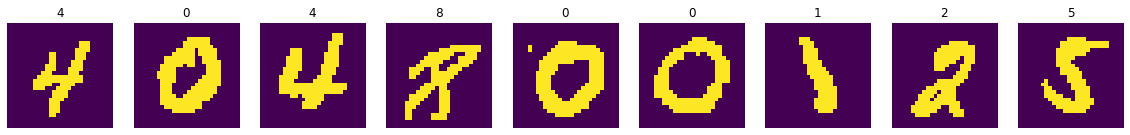

[4 0 4 8 0 0 1 2 5 9 9 5 5 7 9 8]
1


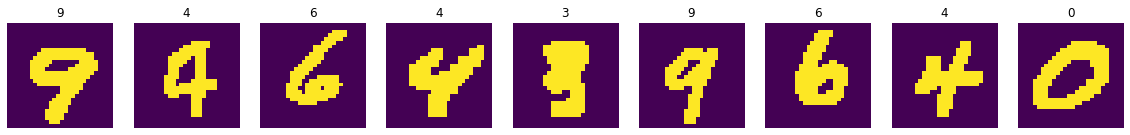

[9 4 6 4 3 9 6 4 0 3 1 1 1 5 9 2]
2


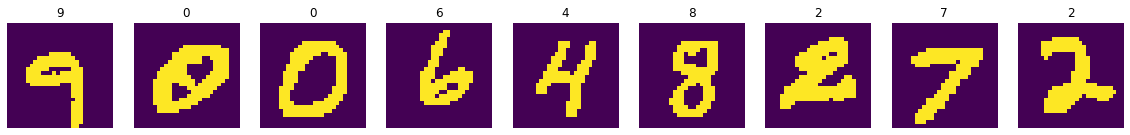

[9 0 0 6 4 8 2 7 2 0 3 2 0 9 7 3]
3


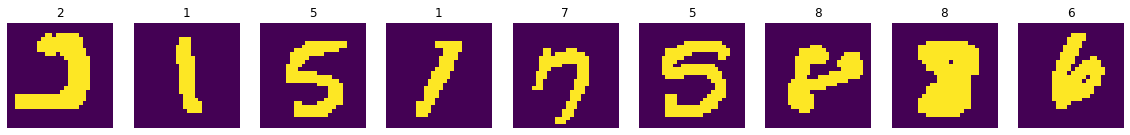

[2 1 5 1 7 5 8 8 6 5 5 0 9 8 3 7]
4


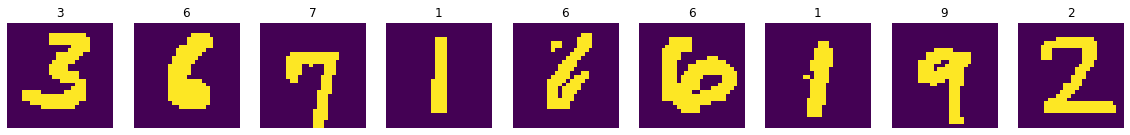

[3 6 7 1 6 6 1 9 2 4 8 1 7 3 1 1]
5


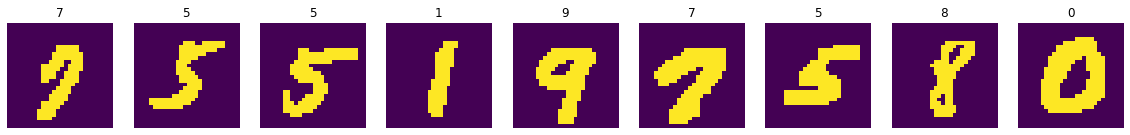

[7 5 5 1 9 7 5 8 0 5 7 1 3 1 9 6]
6


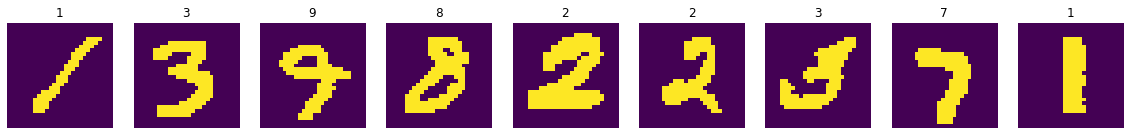

[1 3 9 8 2 2 3 7 1 2 1 5 2 1 0 9]
7


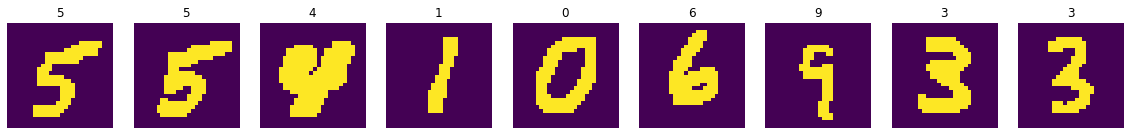

[5 5 4 1 0 6 9 3 3 0 6 4 7 8 0 6]
8


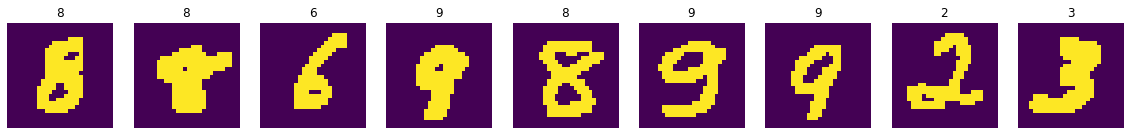

[8 8 6 9 8 9 9 2 3 1 4 8 0 3 2 8]
9


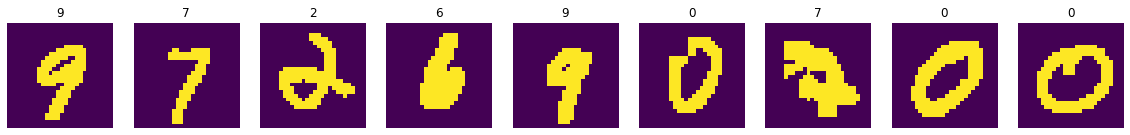

[9 7 2 6 9 0 7 0 0 1 2 9 3 7 1 7]


In [6]:
def get_batches(image,label,input_w,input_h,channels,batch_size):

    queue = tf.train.slice_input_producer([image,label])  #使用tf.train.slice_input_producer实现一个输入的队列
    label = queue[1]                                        #从输入队列里读取标签

    image_c = tf.read_file(queue[0])                        #从输入队列里读取image路径

    image = tf.image.decode_bmp(image_c,channels)           #按照路径读取图片

    image = tf.image.resize_image_with_crop_or_pad(image,input_w,input_h) #修改图片大小


    image = tf.image.per_image_standardization(image) #图像标准化处理，(x - mean) / adjusted_stddev

    image_batch,label_batch = tf.train.batch([image,label],#调用tf.train.batch函数生成批次数据
               batch_size = batch_size,
               num_threads = 64)

    images_batch = tf.cast(image_batch,tf.float32)   #将数据类型转换为float32

    labels_batch = tf.reshape(label_batch,[batch_size])#修改标签的形状shape
    return images_batch,labels_batch


batch_size = 16
image_batches,label_batches = get_batches(image,label,28,28,1,batch_size)



def showresult(subplot,title,thisimg):          #显示单个图片
    p =plt.subplot(subplot)
    p.axis('off')
    #p.imshow(np.asarray(thisimg[0], dtype='uint8'))
    p.imshow(np.reshape(thisimg, (28, 28)))
    p.set_title(title)

def showimg(index,label,img,ntop):   #显示
    plt.figure(figsize=(20,10))     #定义显示图片的宽、高
    plt.axis('off')
    ntop = min(ntop,9)
    print(index)
    for i in range (ntop):
        showresult(100+10*ntop+1+i,label[i],img[i])
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)  #初始化

    coord = tf.train.Coordinator()          #开启列队
    threads = tf.train.start_queue_runners(sess = sess,coord = coord)
    try:
        for step in np.arange(10):
            if coord.should_stop():
                break
            images,label = sess.run([image_batches,label_batches]) #注入数据

            showimg(step,label,images,batch_size)       #显示图片
            print(label)                                 #打印数据

    except tf.errors.OutOfRangeError:
        print("Done!!!")
    finally:
        coord.request_stop()

    coord.join(threads)  